##### Participants: Sahar Sokolik (205937287), Amit Gido (315754606), Bar Mizrahi (315042994), Sarah Hazziza (337891675)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# II) Data Preparation

In [2]:
patients_df = pd.read_csv('PATIENTS.csv')
admissions_df = pd.read_csv('ADMISSIONS.csv')
icustays_df = pd.read_csv('ICUSTAYS.csv')
d_items_df = pd.read_csv('D_ITEMS.csv')
d_labitems_df = pd.read_csv('D_LABITEMS.csv')
labevents_df = pd.read_csv('LABEVENTS.csv')
d_icd_diagnoses_df = pd.read_csv('D_ICD_DIAGNOSES.csv')
diagnoses_icd_df = pd.read_csv('DIAGNOSES_ICD.csv')
chartevents_df = pd.read_csv('CHARTEVENTS.csv')

C:\Users\Sarah\AppData\Local\Temp\ipykernel_32968\2757839035.py:9: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents_df = pd.read_csv('CHARTEVENTS.csv')


In [3]:
# Merge Dataframes with relevant information, diagnosis and labels
merged_icd_df = pd.merge(diagnoses_icd_df, d_icd_diagnoses_df[['icd9_code', 'long_title']], on='icd9_code', how='left')
labevents_df = pd.merge(labevents_df, d_labitems_df[['itemid', 'label']], on='itemid', how='left')
chartevents_df = pd.merge(chartevents_df, d_items_df[['itemid', 'label']], on='itemid', how='left')

In [4]:
# Taking care of the value problems in tables chartevents and labevents (keeping the good values of labevents).

# Merge the dataframes on the specified columns
merged_df = pd.merge(chartevents_df, labevents_df, on=['label', 'subject_id', 'charttime'], suffixes=['_chartevents','_labevents'], how='inner')

# Filter the merged dataframe to keep only the necessary labels
labels_to_keep = set(chartevents_df['label'].unique()).intersection(set(labevents_df['label'].unique()))
filtered_df = merged_df[merged_df['label'].isin(labels_to_keep)]

# Replace values using vectorized operations
filtered_df['value_chartevents'] = filtered_df['value_labevents'].combine_first(filtered_df['value_chartevents'])
filtered_df['valuenum_chartevents'] = filtered_df['valuenum_labevents'].combine_first(filtered_df['valuenum_chartevents'])
filtered_df['valueuom_chartevents'] = filtered_df['valueuom_labevents'].combine_first(filtered_df['valueuom_chartevents'])

# Drop unwanted columns
columns_to_drop = ['row_id_labevents', 'hadm_id_labevents', 'itemid_labevents', 'value_labevents', 'valuenum_labevents', 'valueuom_labevents', 'flag']
filtered_df.drop(columns=columns_to_drop, inplace=True)

# Rename columns to remove suffixes
filtered_df.rename(columns=lambda x: x.replace('_chartevents', ''), inplace=True)

# Set 'row_id' as the index for both DataFrames
filtered_df.set_index('row_id', inplace=True)
chartevents_df.set_index('row_id', inplace=True)

# Update the original chartevents_df with the modified data
chartevents_df.loc[filtered_df.index] = filtered_df

chartevents_df.reset_index(inplace=True)

In [5]:
merged_df = pd.merge(admissions_df, patients_df[['subject_id','gender', 'dob']], on='subject_id', how='left')
merged_df = pd.merge(merged_df, icustays_df[['subject_id', 'hadm_id','icustay_id','intime','outtime','los']], on=['subject_id', 'hadm_id'])
merged_df.drop(columns=['language', 'religion','marital_status','admission_type', 'admission_location','discharge_location'], axis=1, inplace=True)
merged_df_V2 = pd.merge(merged_df, merged_icd_df[['subject_id','hadm_id', 'icd9_code', 'long_title','seq_num']], on=['subject_id','hadm_id'], how='left')

In [6]:
# Finding the diagnosis that were the most prominent for the patients that died in the hospital
target_population = merged_df_V2[(merged_df_V2['hospital_expire_flag'] == 1)]
disease_counts = target_population['long_title'].value_counts()

print("Top diagnosis by occurrence:")
print(disease_counts.head(10))

Top diagnosis by occurrence:
long_title
Acute kidney failure, unspecified                                                                             17
Atrial fibrillation                                                                                           16
Acute respiratory failure                                                                                     16
Unspecified essential hypertension                                                                            15
Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled    12
Pneumonia, organism unspecified                                                                               12
Acidosis                                                                                                      11
Severe sepsis                                                                                                 11
Unspecified septicemia                                  

In [7]:
# Based on the top most showing diagnosis for people who died in the hospital, 
# finding other diagnosis that are related thanks to the keyword "kidney".
kidney_related_diagnoses = merged_df_V2[merged_df_V2['long_title'].str.contains('kidney', case=False, na=False)]
kidney_related_diagnoses['long_title'].value_counts().head()

long_title
Acute kidney failure, unspecified                                                                                         50
Chronic kidney disease, unspecified                                                                                       14
Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified    11
Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage V or end stage renal disease           9
Acute kidney failure with lesion of tubular necrosis                                                                       8
Name: count, dtype: int64

In [8]:
# Based on the top diagnosis in the list, and thanks to further understanding on kidney disease, we will select in the list of diagnosis, 4 diagnosis. 
# Every patients that was diagnosed once with one of them will be included in our target population. 
# Here are the 4 diagnosis: Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage V or end stage renal disease, 
# Chronic kidney disease, unspecified, 
# Acute kidney failure, unspecified, Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified.
# Acute kidney failure with lesion of tubular necrosis.

relevant_diagnoses = ["Acute kidney failure","Chronic kidney disease, unspecified"]

# Choosing patients based on the relevant diagnoses.
filtered_df = merged_df_V2[merged_df_V2['long_title'].str.contains('|'.join(relevant_diagnoses), case=False, na=False)]
filtered_df.reset_index(inplace = True)
filtered_df.drop('index', axis=1, inplace=True)
unique_ids = filtered_df['subject_id'].unique()
print("Number of patients that were diagnosed with the diagnosis chosen:", len(unique_ids))

Number of patients that were diagnosed with the diagnosis chosen: 47


In [9]:
# Retrieving all the diagnoses that were given to all the chosen patients (47) that got one of the relevant diagnoses.
all_diagnoses_patients = merged_df_V2[merged_df_V2['subject_id'].isin(unique_ids)]

In [10]:
# Checking the most prominent diagnoses to choose diagnosis predictors.
all_diagnoses_patients['long_title'].value_counts().head(20)

long_title
Acute kidney failure, unspecified                                                                             50
Atrial fibrillation                                                                                           33
Unspecified essential hypertension                                                                            32
Congestive heart failure, unspecified                                                                         25
Severe sepsis                                                                                                 24
Urinary tract infection, site not specified                                                                   23
Other and unspecified hyperlipidemia                                                                          22
Unspecified septicemia                                                                                        20
Unspecified acquired hypothyroidism                                                  

In [11]:
# Thanks to litterature and by choosing diagnosis that seems interesting to check as predictors,
# choosing Diagnoses of interest and their corresponding column names.
diagnoses_of_interest = {
    'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled': 'diabetes_mellitus',
    'Depressive disorder, not elsewhere classified': 'depressive_disorder',
    'Urinary tract infection, site not specified': 'urinary_infection'
}

# Fill NaN values with an empty string
all_diagnoses_patients['long_title'].fillna('', inplace=True)

# Create new binary columns for each chosen diagnosis.
for diagnosis, column_name in diagnoses_of_interest.items():
    # Group by subject_id and check if the diagnosis exists for each patient
    all_diagnoses_patients[column_name] = all_diagnoses_patients.groupby('subject_id')['long_title'].transform(
        lambda x: int(any(diagnosis in diag for diag in x))
    )
# Drop duplicate rows since we now have the information at the patient level
diagnoses_patients = all_diagnoses_patients.drop_duplicates(subset='subject_id')
diagnoses_patients.drop(['long_title','icd9_code','seq_num'], axis=1, inplace=True)
diagnoses_patients.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,ethnicity,edregtime,edouttime,...,has_chartevents_data,gender,dob,icustay_id,intime,outtime,los,diabetes_mellitus,depressive_disorder,urinary_infection
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,Medicare,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,...,1,F,2094-03-05 00:00:00,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,1,0,0
50,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,Medicare,WHITE,NaN,NaN,...,1,M,2114-06-20 00:00:00,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,1.2938,0,0,0
71,12278,10027,199395,2190-07-13 07:15:00,2190-07-25 14:00:00,NaN,Medicare,WHITE,NaN,NaN,...,1,F,2108-01-15 00:00:00,286020,2190-07-13 10:39:07,2190-07-20 16:55:45,7.2616,1,0,0
83,12280,10029,132349,2139-09-22 10:58:00,2139-10-02 14:29:00,NaN,Medicare,WHITE,2139-09-22 06:03:00,2139-09-22 11:50:00,...,1,M,2061-04-10 00:00:00,226055,2139-09-23 12:37:10,2139-09-25 18:55:04,2.2624,0,0,1
106,12282,10032,140372,2138-04-02 19:52:00,2138-04-15 14:35:00,NaN,Medicare,WHITE,2138-04-02 14:56:00,2138-04-02 20:40:00,...,1,M,2050-03-29 00:00:00,267090,2138-04-08 01:38:18,2138-04-11 18:43:34,3.7120,0,0,0


In [12]:
# Thanks to litterature, choosing lab events and vital sign as predictors.
# Choosing Creatinine test as it measures how well kidneys are performing their job of filtering waste from blood (high value indicate problems).
# Choosing Blood Urea Nitrogen (BUN) since it can indicate that kidneys are not working as they should (high values indicate that).
# Choosing Heart Rate since high values can indicate renal damage.

labels_to_keep = ['Creatinine','Creatinine (0-1.3)', 'BUN','BUN (6-20)','Heart Rate']
target_labels = chartevents_df[chartevents_df['label'].isin(labels_to_keep)]

# Rename complex labels to simpler ones
target_labels['label'] = target_labels['label'].replace({
    'Creatinine (0-1.3)': 'Creatinine',
    'BUN (6-20)': 'BUN'
})

# Drop duplicates based on 'subject_id', 'charttime', and 'label'
target_labels = target_labels.drop_duplicates(subset=['subject_id', 'charttime', 'label'])

In [13]:
# Combining all relevant tables with the new tables.

merged_df = pd.merge(merged_df, icustays_df[['subject_id', 'hadm_id','icustay_id','intime','outtime','los']], on=['subject_id', 'hadm_id'])
final_df = pd.merge(diagnoses_patients, target_labels[['subject_id', 'hadm_id','icustay_id','charttime','value','label']], on=['subject_id','hadm_id', 'icustay_id'], how='left')
final_df

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,ethnicity,edregtime,edouttime,...,icustay_id,intime,outtime,los,diabetes_mellitus,depressive_disorder,urinary_infection,charttime,value,label
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,Medicare,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,...,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,1,0,0,2164-10-23 22:40:00,104,Heart Rate
1,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,Medicare,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,...,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,1,0,0,2164-10-23 23:00:00,99,Heart Rate
2,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,Medicare,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,...,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,1,0,0,2164-10-24 00:00:00,96,Heart Rate
3,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,Medicare,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,...,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,1,0,0,2164-10-24 01:00:00,95,Heart Rate
4,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,Medicare,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,...,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,1,0,0,2164-10-24 02:00:00,92,Heart Rate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,41090,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,NaN,Medicare,WHITE,2180-07-19 04:50:00,2180-07-19 08:23:00,...,238186,2180-07-19 06:56:38,2180-07-20 14:48:45,1.3279,0,0,0,2180-07-20 07:00:00,65,Heart Rate
7694,41090,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,NaN,Medicare,WHITE,2180-07-19 04:50:00,2180-07-19 08:23:00,...,238186,2180-07-19 06:56:38,2180-07-20 14:48:45,1.3279,0,0,0,2180-07-20 08:00:00,74,Heart Rate
7695,41090,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,NaN,Medicare,WHITE,2180-07-19 04:50:00,2180-07-19 08:23:00,...,238186,2180-07-19 06:56:38,2180-07-20 14:48:45,1.3279,0,0,0,2180-07-20 09:00:00,60,Heart Rate
7696,41090,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,NaN,Medicare,WHITE,2180-07-19 04:50:00,2180-07-19 08:23:00,...,238186,2180-07-19 06:56:38,2180-07-20 14:48:45,1.3279,0,0,0,2180-07-20 11:00:00,66,Heart Rate


# III) Preprocessing


In [14]:
# Simplifying the final tables by taking care of problematic outliers values, and creating new columns for lab values 
# that will allow to remove multiple values:
# For each lab type predictor, after reviewing the literature, we chose to create 3 columns for each kind of test: a column regarding the first 
# value that a patient received during his ICU stay, a column for the maximum value he received (since max ones are the problematic ones with those),
# and finally a column for the average of each lab test.

# Convert datetime columns
final_df['admittime'] = pd.to_datetime(final_df['admittime'])
final_df['dob'] = pd.to_datetime(final_df['dob'])
final_df['intime'] = pd.to_datetime(final_df['intime'], format='%Y-%m-%d %H:%M:%S')
final_df['charttime'] = pd.to_datetime(final_df['charttime'], format='%Y-%m-%d %H:%M:%S')

# Calculate age column
final_df['admit_year'] = final_df['admittime'].dt.year
final_df['dob_year'] = final_df['dob'].dt.year
final_df['age'] = final_df['admit_year'] - final_df['dob_year']

final_df['value'] = final_df['value'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
final_df['value'] = pd.to_numeric(final_df['value'], errors='coerce')

# Define normal and critical ranges for lab values
normal_creatinine_range = (0.5, 1.2)
normal_bun_range = (7, 20)
critical_creatinine_high = 4.0
critical_bun_high = 100.0

# Adjust abnormal values t
def adjust_abnormal_values(row):
    if row['label'] == 'Creatinine' and row['value'] > critical_creatinine_high:
        return row['value'] / 100
    elif row['label'] == 'BUN' and row['value'] > critical_bun_high:
        return row['value'] / 10
    else:
        return row['value']

final_df['value'] = final_df.apply(adjust_abnormal_values, axis=1)

# Calculate the time difference between charttime and inttime
final_df['time_diff'] = (final_df['charttime'] - final_df['intime']).dt.total_seconds() / 3600.0

# Initialize lists to hold the results
first_tests = []
max_values = []
mean_values = []

# Define the tests of interest
tests_of_interest = ['Creatinine', 'BUN', 'Heart Rate']

# Process each test of interest
for test in tests_of_interest:
    # Filter for the specific test
    test_df = final_df[final_df['label'] == test]
    
    # First test within 24 hours
    first_test_within_24h = test_df[test_df['time_diff'] <= 24].sort_values(['subject_id', 'charttime']).drop_duplicates('subject_id')
    first_test_within_24h = first_test_within_24h[['subject_id', 'value']].rename(columns={'value': f'first_{test}'})
    
    # Maximum value for the test
    max_test_value = test_df.groupby('subject_id')['value'].max().reset_index().rename(columns={'value': f'max_{test}'})
    
    # Mean value for the test
    mean_test_value = test_df.groupby('subject_id')['value'].mean().reset_index().rename(columns={'value': f'mean_{test}'})
    
    # Append to the results list
    first_tests.append(first_test_within_24h)
    max_values.append(max_test_value)
    mean_values.append(mean_test_value)

# Merge all the results to the original DataFrame
for df in first_tests + max_values + mean_values:
    final_df = final_df.merge(df, on='subject_id', how='left')

# Drop duplicate rows (keeping only the first occurrence)
final_df = final_df.drop_duplicates(subset='subject_id')

# Reset the index
final_df.reset_index(drop=True, inplace=True)

# Drop unnecessary columns
final_df.drop(['time_diff', 'edregtime', 'edouttime', 'deathtime', 'label', 'diagnosis', 'has_chartevents_data', 'value', 'dob', 'admit_year', 'dob_year', 'intime', 'outtime', 'charttime'], axis=1, inplace=True)

final_df

,row_id,subject_id,hadm_id,admittime,dischtime,insurance,ethnicity,hospital_expire_flag,gender,icustay_id,...,age,first_Creatinine,first_BUN,first_Heart Rate,max_Creatinine,max_BUN,max_Heart Rate,mean_Creatinine,mean_BUN,mean_Heart Rate
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,Medicare,BLACK/AFRICAN AMERICAN,0,F,206504,...,70,3.500,11.0,104.0,3.5,11.0,104.0,3.500000,11.000000,82.000000
1,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,Medicare,WHITE,1,M,228977,...,49,0.072,53.0,77.0,4.0,53.0,92.0,1.048000,42.000000,83.333333
2,12278,10027,199395,2190-07-13 07:15:00,2190-07-25 14:00:00,Medicare,WHITE,0,F,286020,...,82,1.200,30.0,91.0,3.1,78.0,176.0,2.483333,53.833333,88.164251
3,12280,10029,132349,2139-09-22 10:58:00,2139-10-02 14:29:00,Medicare,WHITE,0,M,226055,...,78,3.800,50.0,128.0,3.8,66.0,129.0,1.922500,58.000000,97.864865
4,12282,10032,140372,2138-04-02 19:52:00,2138-04-15 14:35:00,Medicare,WHITE,0,M,267090,...,88,1.700,38.0,103.0,1.7,58.0,118.0,1.450000,51.250000,92.770833
5,12283,10033,157235,2132-12-05 02:46:00,2132-12-08 15:15:00,Medicare,WHITE,0,F,254543,...,81,1.000,23.0,98.0,1.0,23.0,103.0,0.900000,19.500000,88.375000
6,12286,10036,189483,2185-03-24 16:56:00,2185-03-26 09:15:00,Medicare,WHITE,1,F,227834,...,300,0.700,56.0,92.0,0.7,56.0,102.0,0.633333,46.333333,78.571429
7,12288,10038,111115,2144-02-09 17:53:00,2144-02-21 13:30:00,Medicare,WHITE,0,F,235482,...,88,1.600,42.0,108.0,1.6,42.0,130.0,1.350000,38.750000,94.878788
8,12295,10045,126949,2129-11-24 00:31:00,2129-12-01 01:45:00,Medicare,WHITE,1,F,203766,...,68,1.800,37.0,50.0,1.8,37.0,107.0,1.337500,31.125000,81.535270
9,12305,10056,100375,2129-05-02 00:12:00,2129-05-06 13:40:00,Medicare,WHITE,0,F,285789,...,83,1.700,23.0,120.0,1.7,23.0,120.0,1.500000,23.000000,94.553191


In [15]:
# Drop subject 10120 since all values are NaN
final_df = final_df[final_df['subject_id'] != 10120]

In [16]:
# After reviewing patient 40204, we can see a problem of updating values,
# therefore fixing NaN values in creatinine for patient 40204 from the labevents dataframe.

creatinine_values = pd.to_numeric(labevents_df[(labevents_df['subject_id'] == 40204) & (labevents_df['label'] == 'Creatinine')]['value'], errors='coerce')
final_df.loc[final_df['subject_id'] == 40204, 'first_Creatinine'] = creatinine_values.iloc[0]
final_df.loc[final_df['subject_id'] == 40204, 'max_Creatinine'] = creatinine_values.mean()
final_df.loc[final_df['subject_id'] == 40204, 'mean_Creatinine'] = creatinine_values.max()

In [17]:
#Taking care of problematic values and missing values in BUN columns.

# Changing the problematic age patients with patients mean age
mean_age = final_df[final_df['age'] <= 120]['age'].mean()
final_df.loc[final_df['age'] > 120, 'age'] = mean_age

# Filling missing NaN values in the BUN column with the average value of the column.
meanfirst_bun = final_df['first_BUN'].mean()
meanmax_bun = final_df['max_BUN'].mean()
meanmean_bun = final_df['mean_BUN'].mean()
final_df['first_BUN'].fillna(meanfirst_bun, inplace=True)
final_df['mean_BUN'].fillna(meanmax_bun, inplace=True)
final_df['max_BUN'].fillna(meanmean_bun, inplace=True)

In [18]:
nan_counts = final_df.isna().sum()
print(nan_counts)

row_id                  0
subject_id              0
hadm_id                 0
admittime               0
dischtime               0
insurance               0
ethnicity               0
hospital_expire_flag    0
gender                  0
icustay_id              0
los                     0
diabetes_mellitus       0
depressive_disorder     0
urinary_infection       0
age                     0
first_Creatinine        0
first_BUN               0
first_Heart Rate        0
max_Creatinine          0
max_BUN                 0
max_Heart Rate          0
mean_Creatinine         0
mean_BUN                0
mean_Heart Rate         0
dtype: int64


# IV) EDA

### 1. Variable Distributions
#### We will use histograms and count plots to present the distributions of demographic variables, diagnostic variables, and laboratory tests.

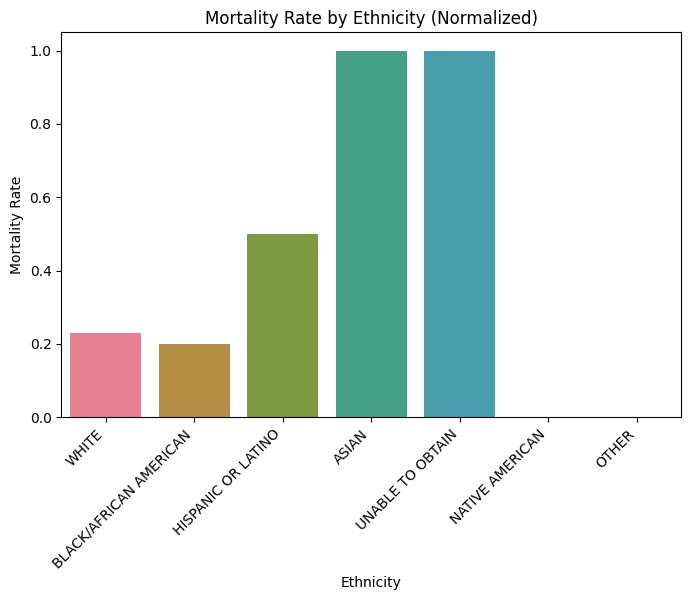

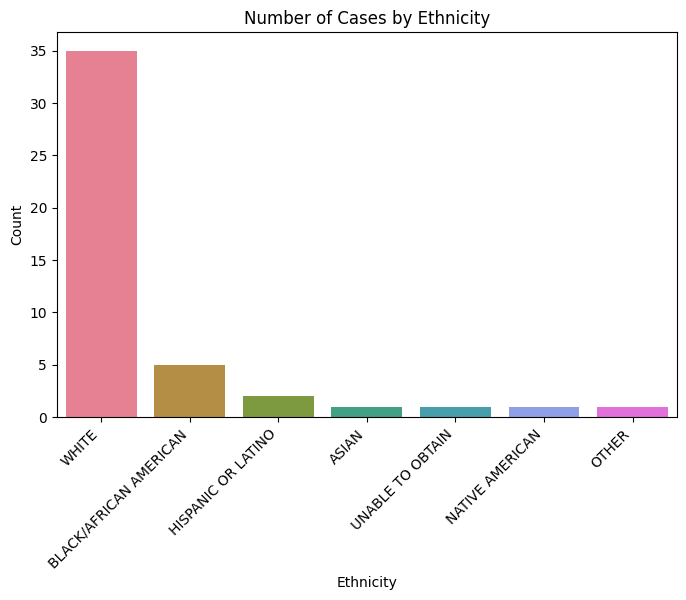

In [19]:
# Replace 'HISPANIC/LATINO - PUERTO RICAN' with 'HISPANIC OR LATINO'
final_df['ethnicity'] = final_df['ethnicity'].replace('HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC OR LATINO')
final_df['ethnicity'] = final_df['ethnicity'].replace('AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'NATIVE AMERICAN')

# Calculate mortality rate for each ethnicity
ethnicity_mortality = final_df.groupby('ethnicity')['hospital_expire_flag'].mean().reset_index()
ethnicity_mortality.columns = ['ethnicity', 'mortality_rate']

# Calculate the number of cases for each ethnicity
ethnicity_counts = final_df['ethnicity'].value_counts().reset_index()
ethnicity_counts.columns = ['ethnicity', 'count']

# Merge the two tables
ethnicity_data = pd.merge(ethnicity_mortality, ethnicity_counts, on='ethnicity')

# Sort labels according to the original order in the data
sorted_ethnicities = final_df['ethnicity'].value_counts().index.tolist()

# Set the color palette
colors = sns.color_palette("husl", len(sorted_ethnicities))

# Visualization of mortality rate by ethnicity
plt.figure(figsize=(8, 5))
sns.barplot(data=ethnicity_data, x='ethnicity', y='mortality_rate', order=sorted_ethnicities, palette=colors)
plt.title('Mortality Rate by Ethnicity (Normalized)')
plt.xlabel('Ethnicity')
plt.ylabel('Mortality Rate')
plt.xticks(rotation=45, ha='right')
plt.show()

# Visualization of number of cases by ethnicity
plt.figure(figsize=(8, 5))
sns.barplot(data=ethnicity_data, x='ethnicity', y='count', order=sorted_ethnicities, palette=colors)
plt.title('Number of Cases by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


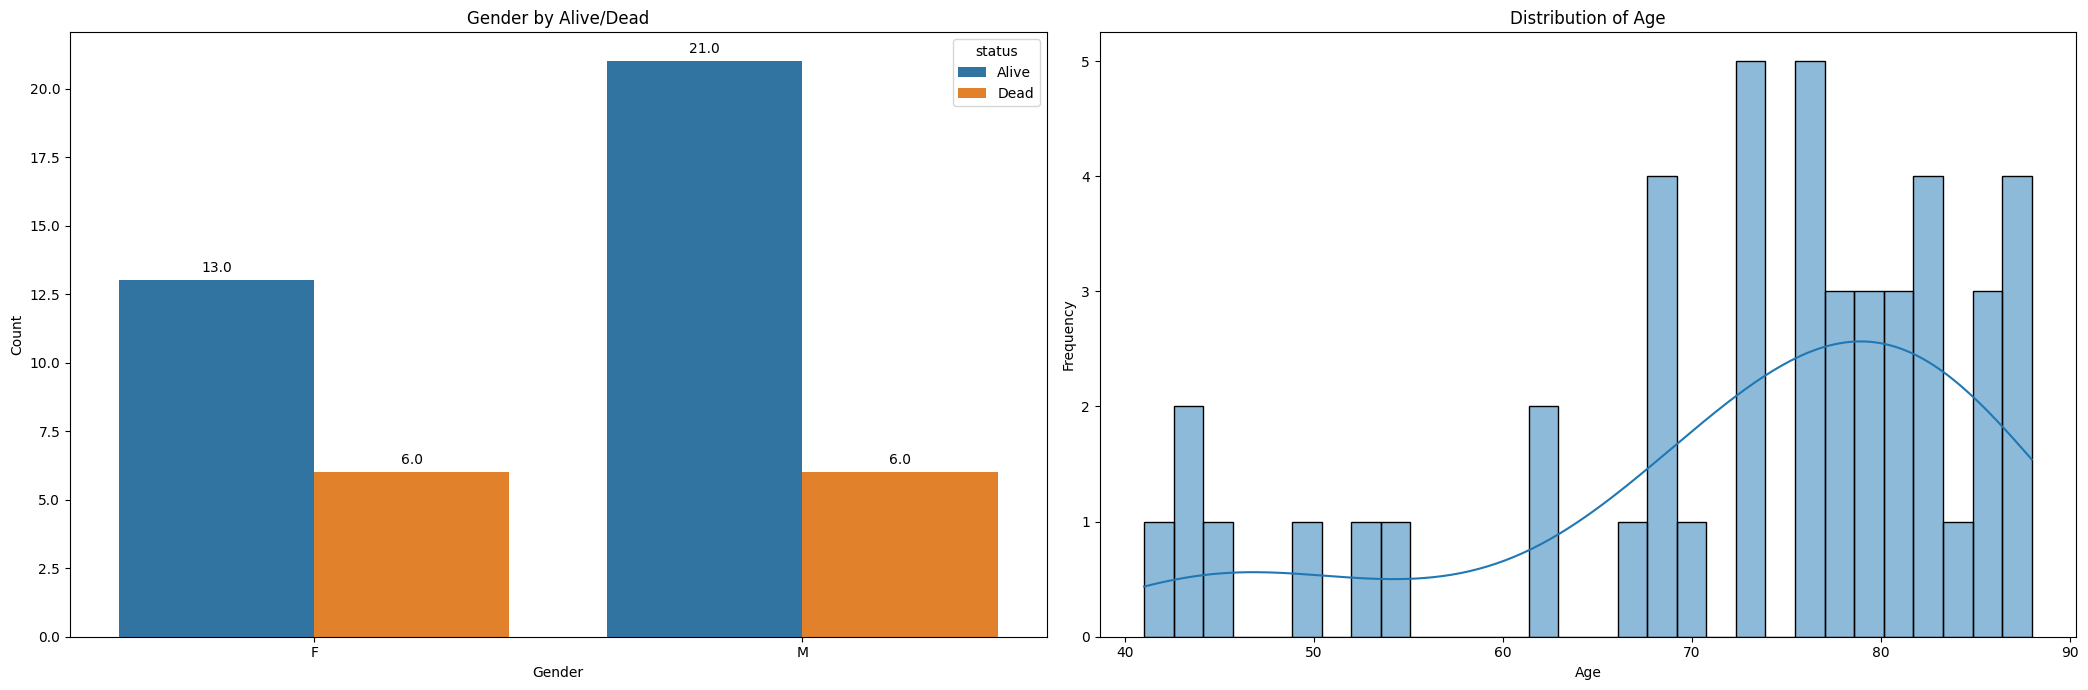

In [20]:
# Create a new variable for Alive/Dead status
final_df['status'] = final_df['hospital_expire_flag'].apply(lambda x: 'Dead' if x == 1 else 'Alive')

# Set the size for the two plots
fig, axes = plt.subplots(1, 2, figsize=(21, 7))

# Plot 1: Gender distribution by Alive/Dead status and the number of people in each gender
bar_plot = sns.countplot(data=final_df, x='gender', hue='status', ax=axes[0])
axes[0].set_title('Gender by Alive/Dead')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

# Add numbers above the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

# Plot 2: Age distribution
sns.histplot(final_df['age'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


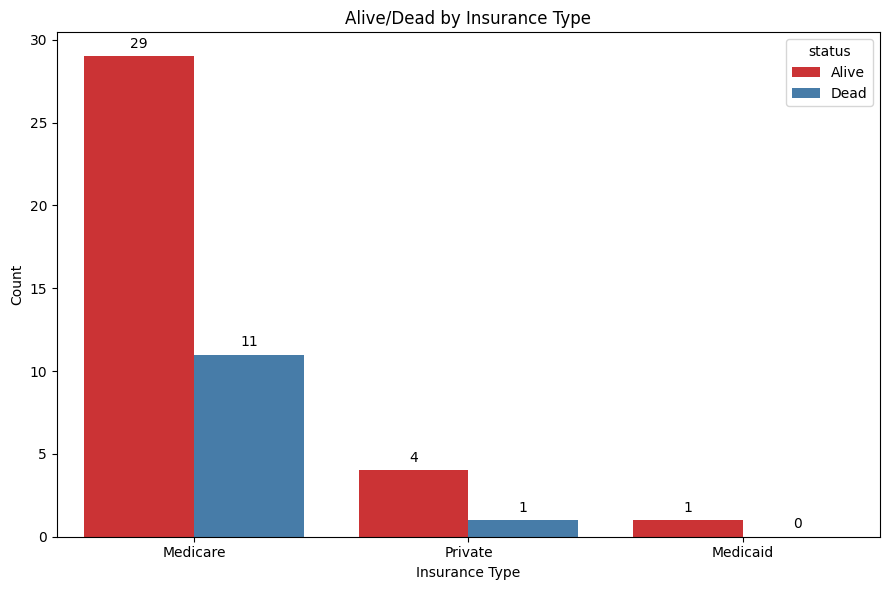

In [21]:
# Creating a new variable for Alive/Dead status
final_df['status'] = final_df['hospital_expire_flag'].apply(lambda x: 'Dead' if x == 1 else 'Alive')

# Plot setup
plt.figure(figsize=(9, 6))

# Grouped bar chart for Alive/Dead by insurance type
bar_plot = sns.countplot(data=final_df, x='insurance', hue='status', palette='Set1')
plt.title('Alive/Dead by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Count')

# Adding numbers on the bars
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='center', xytext=(0, 9),
                      textcoords='offset points')

plt.tight_layout()
plt.show()

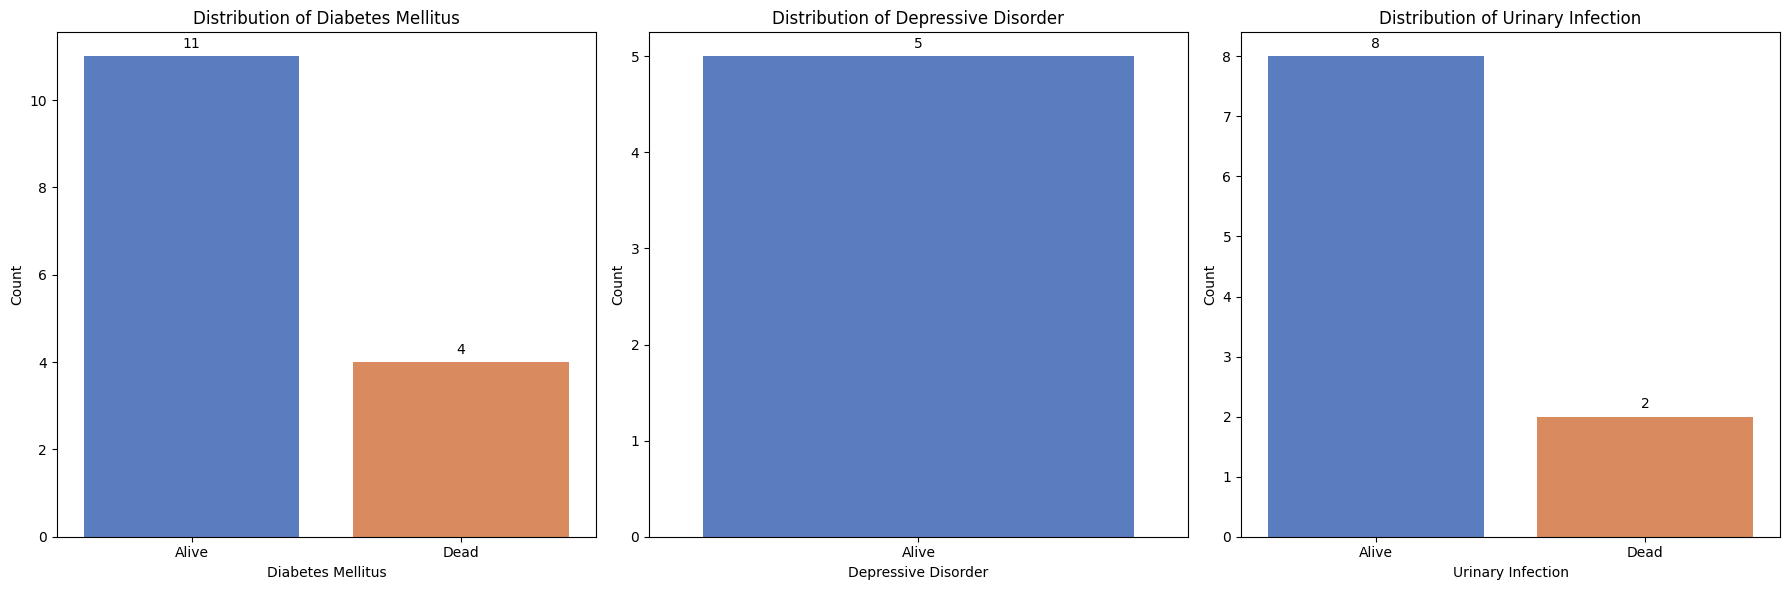

In [22]:
final_df['status'] = final_df['hospital_expire_flag'].apply(lambda x: 'Dead' if x == 1 else 'Alive')

# Set the size for the diagnosis plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Distribution of Diabetes Mellitus
diabetes_df = final_df[final_df['diabetes_mellitus'] == 1]
bar_plot_1 = sns.countplot(data=diabetes_df, x='status', ax=axes[0], palette='muted')
axes[0].set_title('Distribution of Diabetes Mellitus')
axes[0].set_xlabel('Diabetes Mellitus')
axes[0].set_ylabel('Count')

# Add numbers above the bars
for p in bar_plot_1.patches:
    bar_plot_1.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

# Plot 2: Distribution of Depressive Disorder
cerebrovascular_df = final_df[final_df['depressive_disorder'] == 1]
bar_plot_2 = sns.countplot(data=cerebrovascular_df, x='status', ax=axes[1], palette='muted')
axes[1].set_title('Distribution of Depressive Disorder')
axes[1].set_xlabel('Depressive Disorder')
axes[1].set_ylabel('Count')

# Add numbers above the bars
for p in bar_plot_2.patches:
    bar_plot_2.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

# Plot 3: Distribution of Urinary Infection
infection_catheter_df = final_df[final_df['urinary_infection'] == 1]
bar_plot_3 = sns.countplot(data=infection_catheter_df, x='status', ax=axes[2], palette='muted')
axes[2].set_title('Distribution of Urinary Infection')
axes[2].set_xlabel('Urinary Infection')
axes[2].set_ylabel('Count')

# Add numbers above the bars
for p in bar_plot_3.patches:
    bar_plot_3.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

plt.tight_layout()
plt.show()


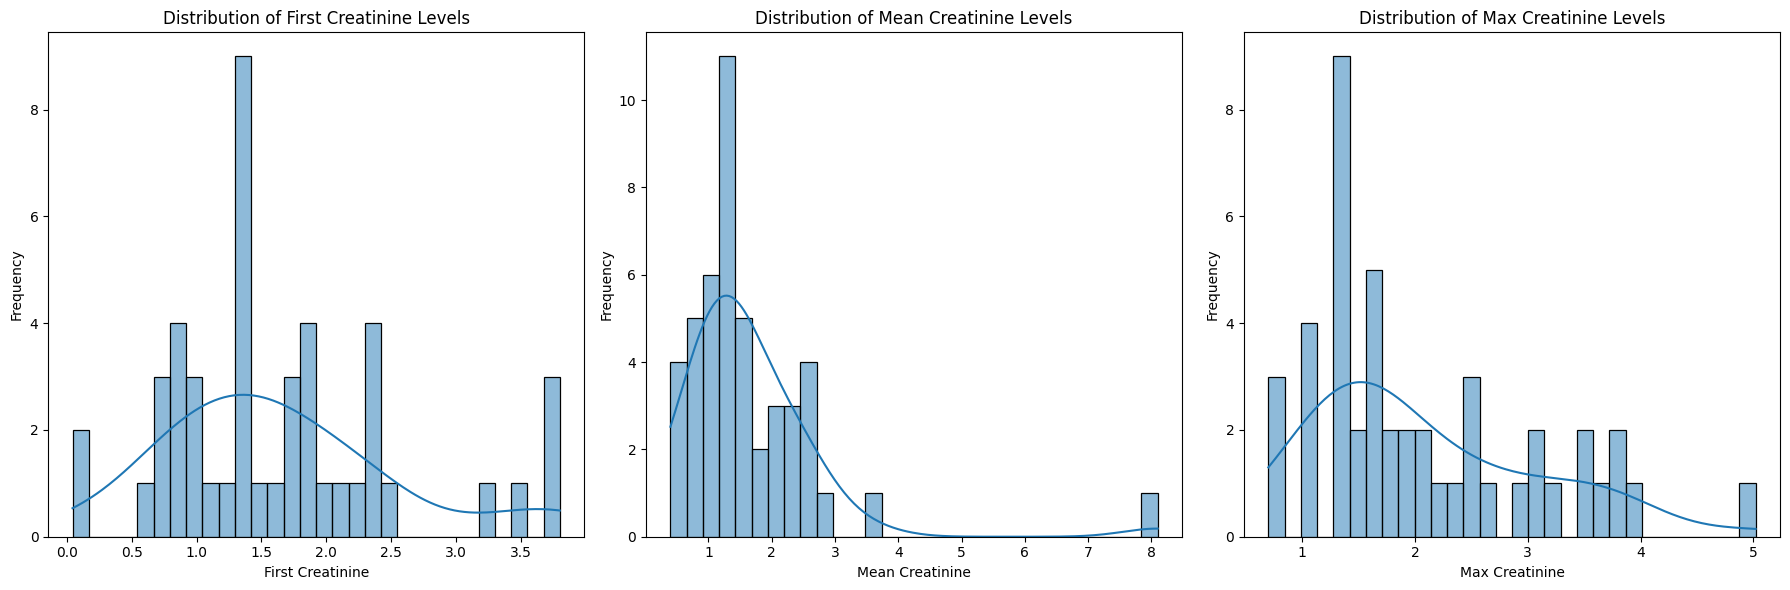

In [23]:
# Set the size for the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Distribution of first Creatinine value
sns.histplot(final_df['first_Creatinine'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of First Creatinine Levels')
axes[0].set_xlabel('First Creatinine')
axes[0].set_ylabel('Frequency')

# Plot 2: Distribution of mean Creatinine value
sns.histplot(final_df['mean_Creatinine'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Mean Creatinine Levels')
axes[1].set_xlabel('Mean Creatinine')
axes[1].set_ylabel('Frequency')

# Plot 3: Distribution of max Creatinine value
sns.histplot(final_df['max_Creatinine'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Max Creatinine Levels')
axes[2].set_xlabel('Max Creatinine')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


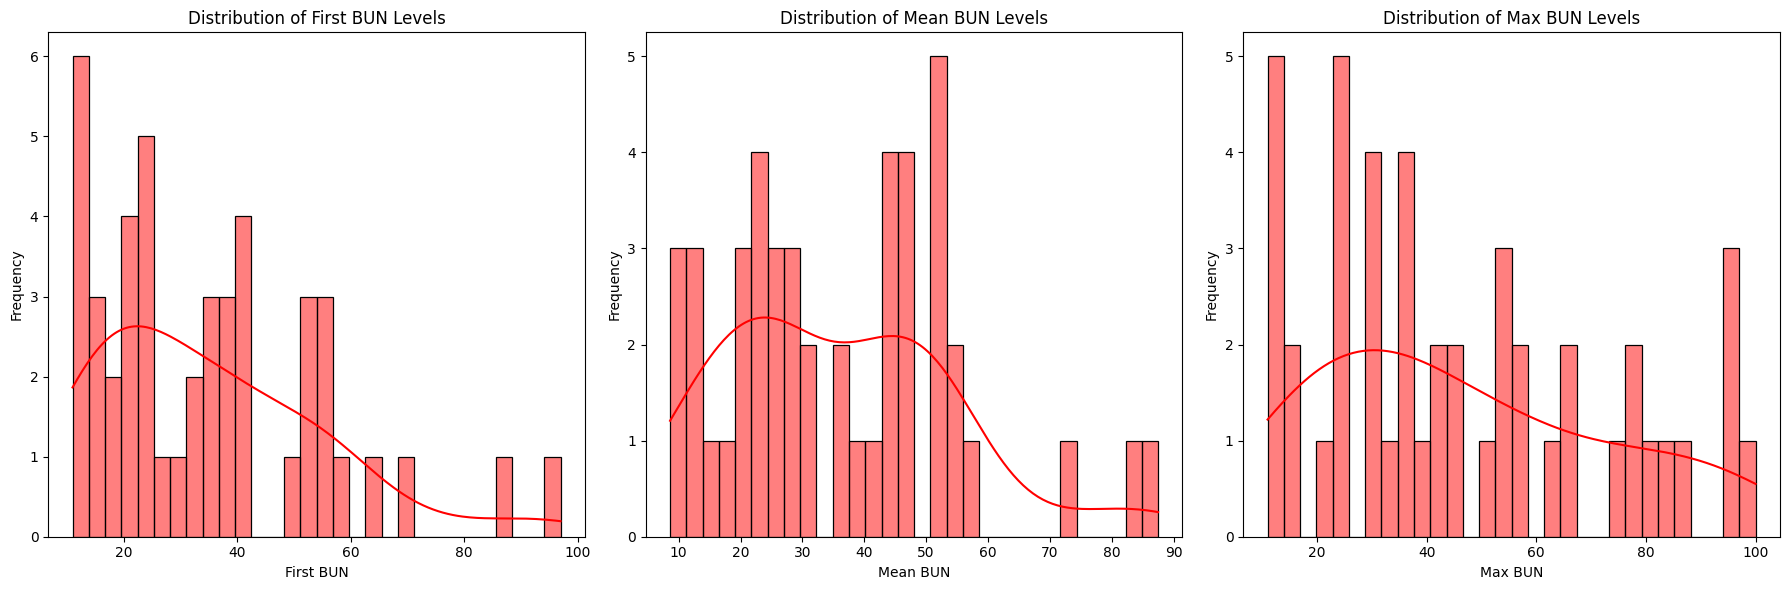

In [24]:
# Set the size for the plots for BUN
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Distribution of the first BUN value
sns.histplot(final_df['first_BUN'], bins=30, kde=True, ax=axes[0], color='red')
axes[0].set_title('Distribution of First BUN Levels')
axes[0].set_xlabel('First BUN')
axes[0].set_ylabel('Frequency')

# Plot 2: Distribution of the mean BUN value
sns.histplot(final_df['mean_BUN'], bins=30, kde=True, ax=axes[1], color='red')
axes[1].set_title('Distribution of Mean BUN Levels')
axes[1].set_xlabel('Mean BUN')
axes[1].set_ylabel('Frequency')

# Plot 3: Distribution of the max BUN value
sns.histplot(final_df['max_BUN'], bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Distribution of Max BUN Levels')
axes[2].set_xlabel('Max BUN')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


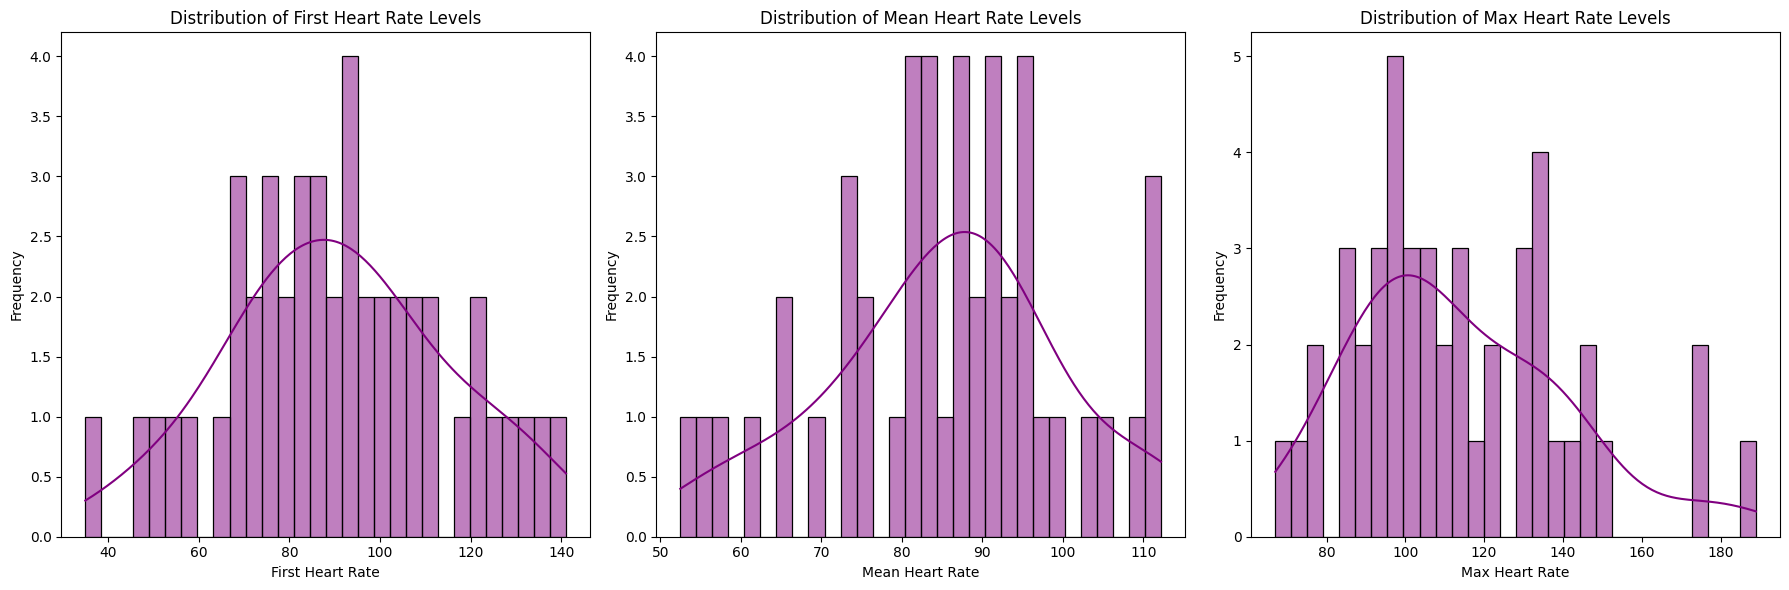

In [25]:
# Set the size for the plots for Heart Rate
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Distribution of the first Heart Rate value
sns.histplot(final_df['first_Heart Rate'], bins=30, kde=True, ax=axes[0], color='purple')
axes[0].set_title('Distribution of First Heart Rate Levels')
axes[0].set_xlabel('First Heart Rate')
axes[0].set_ylabel('Frequency')

# Plot 2: Distribution of the mean Heart Rate value
sns.histplot(final_df['mean_Heart Rate'], bins=30, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Distribution of Mean Heart Rate Levels')
axes[1].set_xlabel('Mean Heart Rate')
axes[1].set_ylabel('Frequency')

# Plot 3: Distribution of the max Heart Rate value
sns.histplot(final_df['max_Heart Rate'], bins=30, kde=True, ax=axes[2], color='purple')
axes[2].set_title('Distribution of Max Heart Rate Levels')
axes[2].set_xlabel('Max Heart Rate')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### 2. Identifying Outliers:
#### We will use box plots to identify outliers.

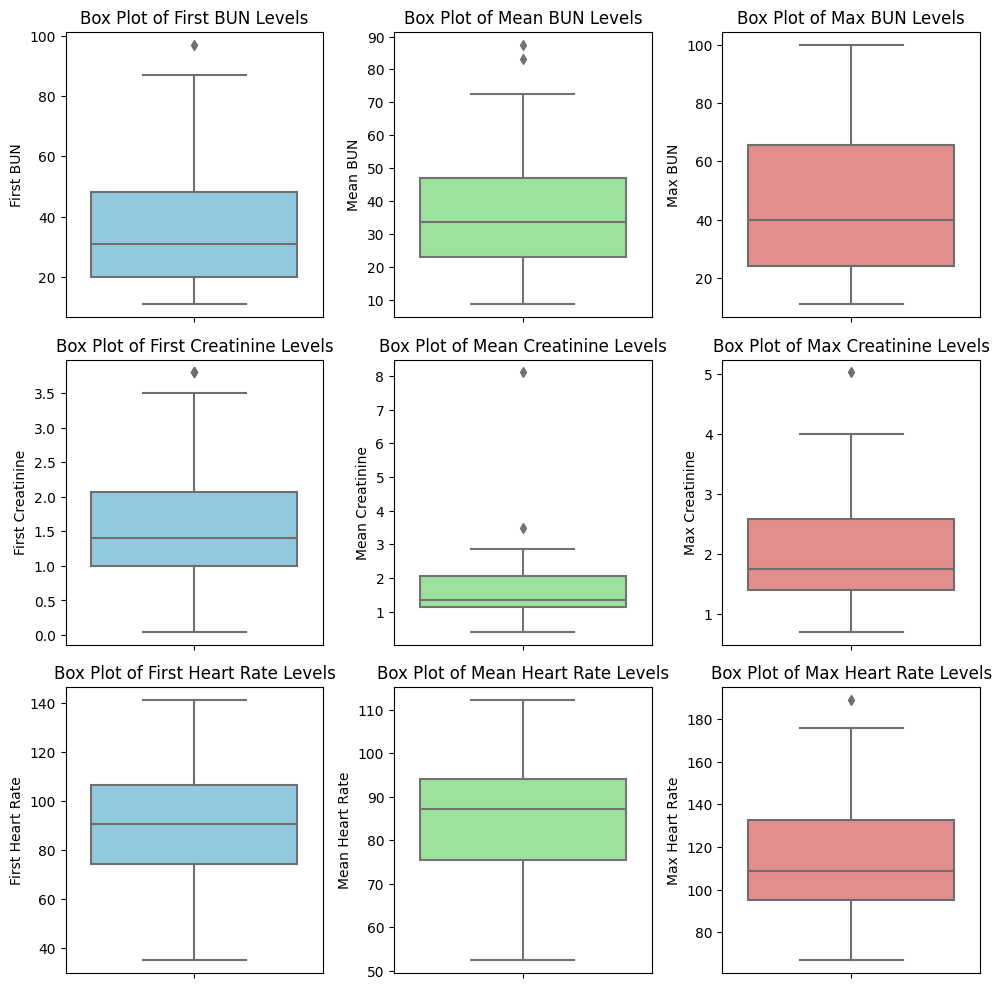

In [26]:
# Set the size for the plots for Box Plots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# First Row: Box Plots for BUN values
sns.boxplot(data=final_df, y='first_BUN', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Box Plot of First BUN Levels')
axes[0, 0].set_ylabel('First BUN')

sns.boxplot(data=final_df, y='mean_BUN', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Box Plot of Mean BUN Levels')
axes[0, 1].set_ylabel('Mean BUN')

sns.boxplot(data=final_df, y='max_BUN', ax=axes[0, 2], color='lightcoral')
axes[0, 2].set_title('Box Plot of Max BUN Levels')
axes[0, 2].set_ylabel('Max BUN')

# Second Row: Box Plots for Creatinine values
sns.boxplot(data=final_df, y='first_Creatinine', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Box Plot of First Creatinine Levels')
axes[1, 0].set_ylabel('First Creatinine')

sns.boxplot(data=final_df, y='mean_Creatinine', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Box Plot of Mean Creatinine Levels')
axes[1, 1].set_ylabel('Mean Creatinine')

sns.boxplot(data=final_df, y='max_Creatinine', ax=axes[1, 2], color='lightcoral')
axes[1, 2].set_title('Box Plot of Max Creatinine Levels')
axes[1, 2].set_ylabel('Max Creatinine')

# Third Row: Box Plots for Heart Rate values
sns.boxplot(data=final_df, y='first_Heart Rate', ax=axes[2, 0], color='skyblue')
axes[2, 0].set_title('Box Plot of First Heart Rate Levels')
axes[2, 0].set_ylabel('First Heart Rate')

sns.boxplot(data=final_df, y='mean_Heart Rate', ax=axes[2, 1], color='lightgreen')
axes[2, 1].set_title('Box Plot of Mean Heart Rate Levels')
axes[2, 1].set_ylabel('Mean Heart Rate')

sns.boxplot(data=final_df, y='max_Heart Rate', ax=axes[2, 2], color='lightcoral')
axes[2, 2].set_title('Box Plot of Max Heart Rate Levels')
axes[2, 2].set_ylabel('Max Heart Rate')

# Adding layout and showing the plots
plt.tight_layout()
plt.show()


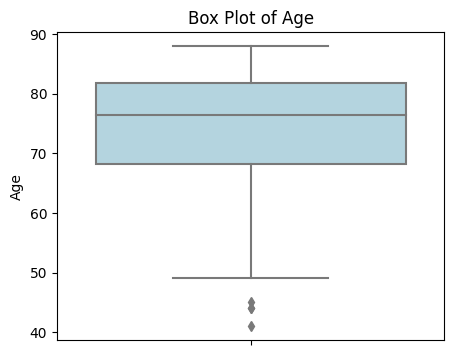

In [27]:
# Create Box Plot for age
plt.figure(figsize=(5, 4))
sns.boxplot(data=final_df, y='age', color='lightblue')
plt.title('Box Plot of Age')
plt.ylabel('Age')
plt.show()

### 3. Scatter Plots:
#### We will start by creating scatter plots to examine the relationships between variables such as age, BUN values, and creatinine levels with the final outcome (alive/dead).

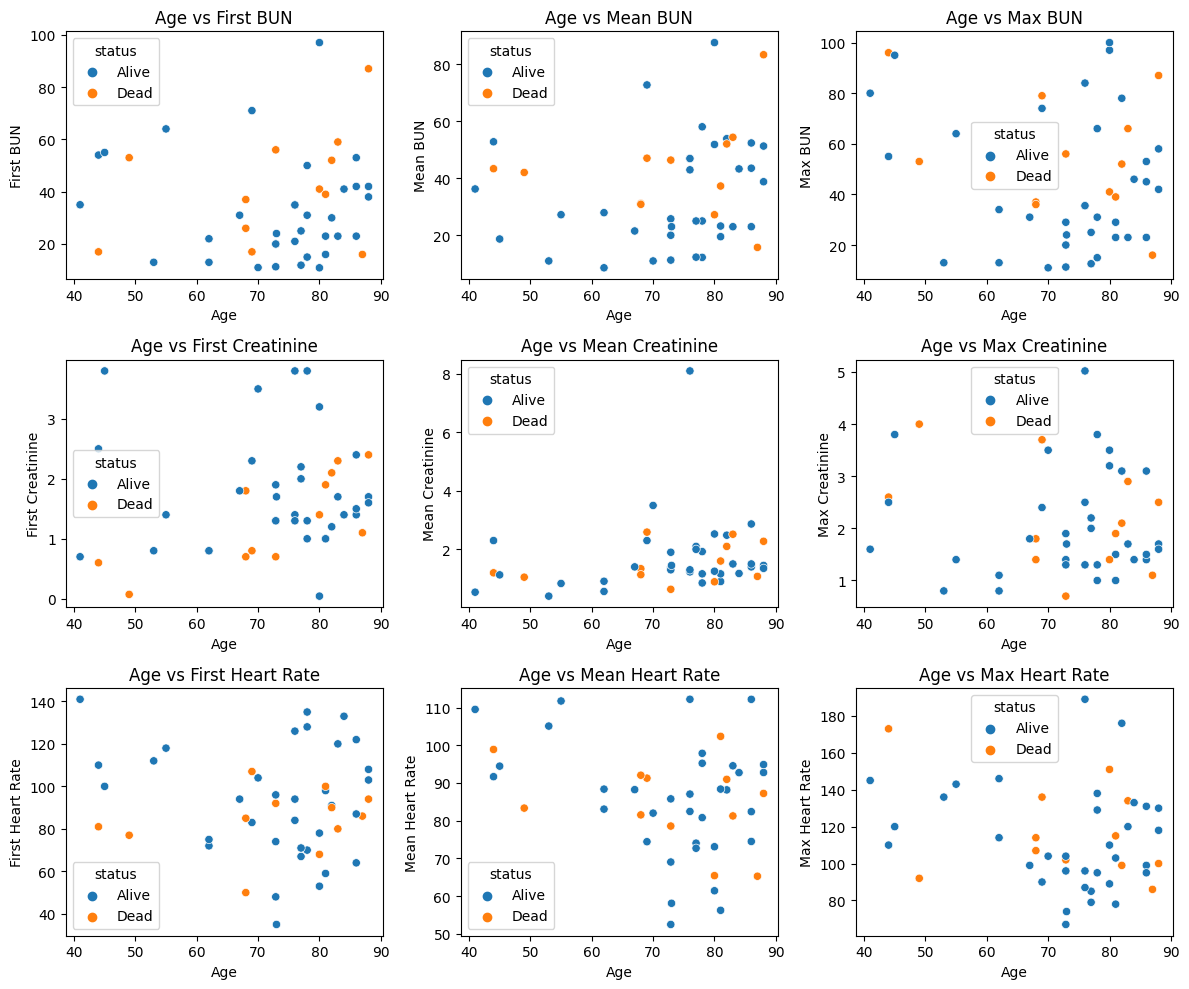

In [28]:
# Adding a 'status' column indicating alive/dead
final_df['status'] = final_df['hospital_expire_flag'].map({0: 'Alive', 1: 'Dead'})

# Defining the size and layout
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# Graph 1: Scatter plot between age and first BUN value
sns.scatterplot(data=final_df, x='age', y='first_BUN', hue='status', ax=axes[0, 0])
axes[0, 0].set_title('Age vs First BUN')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('First BUN')

# Graph 2: Scatter plot between age and mean BUN value
sns.scatterplot(data=final_df, x='age', y='mean_BUN', hue='status', ax=axes[0, 1])
axes[0, 1].set_title('Age vs Mean BUN')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Mean BUN')

# Graph 3: Scatter plot between age and max BUN value
sns.scatterplot(data=final_df, x='age', y='max_BUN', hue='status', ax=axes[0, 2])
axes[0, 2].set_title('Age vs Max BUN')
axes[0, 2].set_xlabel('Age')
axes[0, 2].set_ylabel('Max BUN')

# Graph 4: Scatter plot between age and first Creatinine value
sns.scatterplot(data=final_df, x='age', y='first_Creatinine', hue='status', ax=axes[1, 0])
axes[1, 0].set_title('Age vs First Creatinine')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('First Creatinine')

# Graph 5: Scatter plot between age and mean Creatinine value
sns.scatterplot(data=final_df, x='age', y='mean_Creatinine', hue='status', ax=axes[1, 1])
axes[1, 1].set_title('Age vs Mean Creatinine')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Mean Creatinine')

# Graph 6: Scatter plot between age and max Creatinine value
sns.scatterplot(data=final_df, x='age', y='max_Creatinine', hue='status', ax=axes[1, 2])
axes[1, 2].set_title('Age vs Max Creatinine')
axes[1, 2].set_xlabel('Age')
axes[1, 2].set_ylabel('Max Creatinine')

# Graph 7: Scatter plot between age and first Heart Rate value
sns.scatterplot(data=final_df, x='age', y='first_Heart Rate', hue='status', ax=axes[2, 0])
axes[2, 0].set_title('Age vs First Heart Rate')
axes[2, 0].set_xlabel('Age')
axes[2, 0].set_ylabel('First Heart Rate')

# Graph 8: Scatter plot between age and mean Heart Rate value
sns.scatterplot(data=final_df, x='age', y='mean_Heart Rate', hue='status', ax=axes[2, 1])
axes[2, 1].set_title('Age vs Mean Heart Rate')
axes[2, 1].set_xlabel('Age')
axes[2, 1].set_ylabel('Mean Heart Rate')

# Graph 9: Scatter plot between age and max Heart Rate value
sns.scatterplot(data=final_df, x='age', y='max_Heart Rate', hue='status', ax=axes[2, 2])
axes[2, 2].set_title('Age vs Max Heart Rate')
axes[2, 2].set_xlabel('Age')
axes[2, 2].set_ylabel('Max Heart Rate')

# Displaying the plots
plt.tight_layout()
plt.show()

### 4. Correlation Heatmap
#### Now we will create a heatmap of the correlation to examine the relationships between all variables:

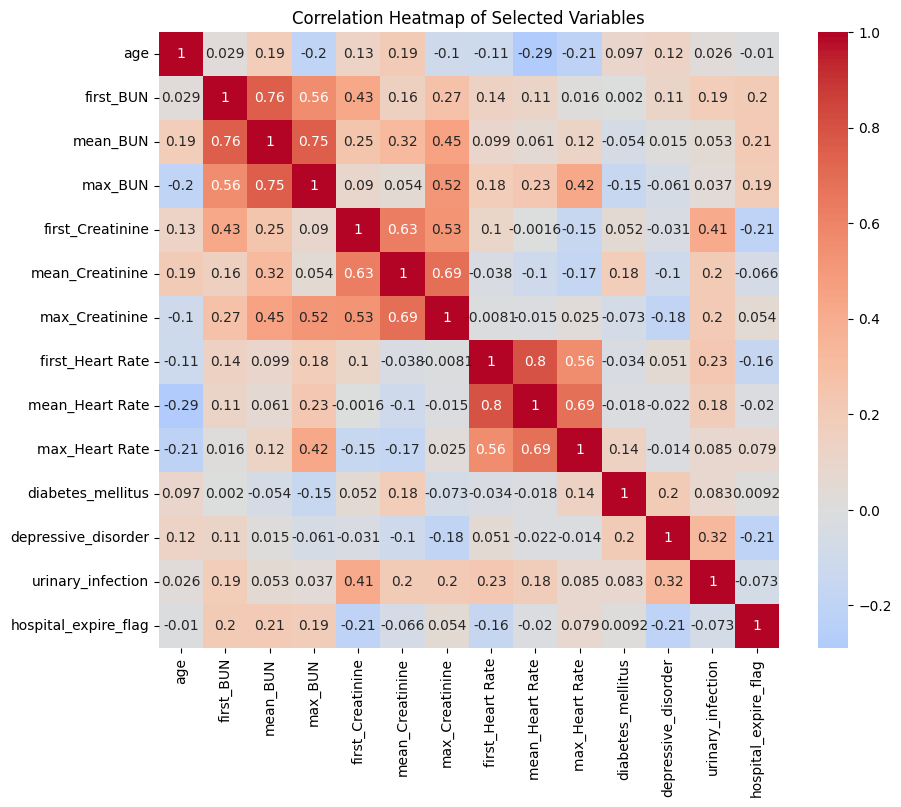

In [29]:
# Adding selected variables
selected_variables = [
    'age', 'first_BUN', 'mean_BUN', 'max_BUN', 
    'first_Creatinine', 'mean_Creatinine', 'max_Creatinine', 
    'first_Heart Rate', 'mean_Heart Rate', 'max_Heart Rate',
    'diabetes_mellitus', 'depressive_disorder', 'urinary_infection', 
    'hospital_expire_flag'
]

# Creating a correlation matrix
correlation_matrix = final_df[selected_variables].corr()

# Creating a correlation heatmap of selected variables
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Selected Variables')
plt.show()

### 5. Statistical Test
#### To examine the robustness of relationships between predictor variables and the target variable using statistical tests, we will perform the following steps:
##### 1. Selecting the Target Variable and Predictor Variables:
###### We will choose our target variable, which is hospital_expire_flag, and predictor variables such as age, creatinine, and BUN.
##### 2. Conducting Appropriate Statistical Tests:
###### We will employ the Chi-Square Test to explore relationships among categorical variables, while opting for the t-test to evaluate associations between continuous variables and the target variable under the assumption of normality, and the Mann-Whitney U Test when normality assumptions are not met.

In [30]:
# Testing the relationship between age and hospital_expire_flag using t-test
alive_age = final_df[final_df['hospital_expire_flag'] == 0]['age']
dead_age = final_df[final_df['hospital_expire_flag'] == 1]['age']
t_stat, p_value = stats.ttest_ind(alive_age, dead_age)
print(f"T-test for age: t_stat={t_stat}, p_value={p_value}")

# Testing the relationship between Creatinine and hospital_expire_flag using t-test
alive_creatinine = final_df[final_df['hospital_expire_flag'] == 0]['mean_Creatinine']
dead_creatinine = final_df[final_df['hospital_expire_flag'] == 1]['mean_Creatinine']
t_stat, p_value = stats.ttest_ind(alive_creatinine, dead_creatinine)
print(f"T-test for mean_Creatinine: t_stat={t_stat}, p_value={p_value}")

# Testing the relationship between BUN and hospital_expire_flag using Mann-Whitney U Test
alive_bun = final_df[final_df['hospital_expire_flag'] == 0]['mean_BUN']
dead_bun = final_df[final_df['hospital_expire_flag'] == 1]['mean_BUN']
u_stat, p_value_bun = stats.mannwhitneyu(alive_bun, dead_bun)
print(f"Mann-Whitney U Test for mean_BUN: U_stat={u_stat}, p_value={p_value_bun}")

# Testing the relationship between Heart Rate and hospital_expire_flag using t-test
alive_heart_rate = final_df[final_df['hospital_expire_flag'] == 0]['mean_Heart Rate']
dead_heart_rate = final_df[final_df['hospital_expire_flag'] == 1]['mean_Heart Rate']
t_stat, p_value = stats.ttest_ind(alive_heart_rate, dead_heart_rate)
print(f"T-test for mean_Heart Rate: t_stat={t_stat}, p_value={p_value}")

# Testing the relationship between gender and hospital_expire_flag using Chi-Square Test
contingency_table = pd.crosstab(final_df['gender'], final_df['hospital_expire_flag'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Test for gender: chi2={chi2}, p_value={p}")

# Chi-Square Test for diabetes_mellitus
contingency_table_dm = pd.crosstab(final_df['diabetes_mellitus'], final_df['hospital_expire_flag'])
chi2_dm, p_dm, dof_dm, expected_dm = stats.chi2_contingency(contingency_table_dm)
print(f"Chi-Square Test for diabetes_mellitus: chi2={chi2_dm}, p_value={p_dm}")

# Chi-Square Test for cerebrovascular_disease
contingency_table_cd = pd.crosstab(final_df['depressive_disorder'], final_df['hospital_expire_flag'])
chi2_cd, p_cd, dof_cd, expected_cd = stats.chi2_contingency(contingency_table_cd)
print(f"Chi-Square Test for depressive_disorder: chi2={chi2_cd}, p_value={p_cd}")

# Chi-Square Test for infection_catheter
contingency_table_ic = pd.crosstab(final_df['urinary_infection'], final_df['hospital_expire_flag'])
chi2_ic, p_ic, dof_ic, expected_ic = stats.chi2_contingency(contingency_table_ic)
print(f"Chi-Square Test for urinary_infection: chi2={chi2_ic}, p_value={p_ic}")


T-test for age: t_stat=0.06923367171705226, p_value=0.9451173153124106
T-test for mean_Creatinine: t_stat=0.44074161983850324, p_value=0.6615580210764506
Mann-Whitney U Test for mean_BUN: U_stat=141.0, p_value=0.11786100553396059
T-test for mean_Heart Rate: t_stat=0.1354189287835617, p_value=0.8928982926625598
Chi-Square Test for gender: chi2=0.13736001223101335, p_value=0.7109197515495319
Chi-Square Test for diabetes_mellitus: chi2=0.0, p_value=1.0
Chi-Square Test for depressive_disorder: chi2=0.7529172644667624, p_value=0.3855541764532162
Chi-Square Test for urinary_infection: chi2=0.007829520697167748, p_value=0.9294915405421293
